# การสร้าง Model สำหรับ Text Classification โดยใช้ Bag-of-word Feature กับ Standard Feedforward Neural Network

In [4]:
pip install deepcut

  Using cached deepcut-0.7.0.0-py3-none-any.whl (2.0 MB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
import csv
import numpy as np
import deepcut
from keras.models import Model
from keras.layers import Input, Dense
from tensorflow.keras.utils import to_categorical, set_random_seed
import matplotlib.pyplot as plt
from random import shuffle
from sklearn.metrics import confusion_matrix

set_random_seed(99)

**Read raw data form music_tu.csv.**

ขอให้ Copy File music_tu.csv ที่จะใช้ในตัวอย่างนี้จาก url ด้านล่างนี้ลงใน Google Drive ของตนเอง

https://drive.google.com/file/d/1B62Bl-mmZPrPmPWQDTczXJ_L6YPTwkK6/view?usp=sharing

และเปลี่ยนตำแหน่งของไฟล์ music_tu.csv ใน Source Code ด้านล่างนี้จาก '/content/drive/MyDrive/music_tu.csv' ไปเป็นตำแหน่งที่นักศึกษา Copy Folder ของภาพไว้ใน Google Drive ของตัวเอง

In [51]:
# Read input.txt and ans.txt into separate lists
with open('input.txt', 'r', encoding='utf-8-sig') as input_file:
    input_data = [line.strip().split('::')[1] for line in input_file]

with open('ans.txt', 'r', encoding='utf-8-sig') as ans_file:
    ans_data = [line.strip().split('::')[1] for line in ans_file]

# Shuffle the input data
shuffle(input_data)

# Create a list to store the combined data
combined_data = []

# Iterate through the input and ans data and combine them
for input_line, ans_line in zip(input_data, ans_data):
    combined_line = [ans_line, input_line]
    combined_data.append(combined_line)

# Shuffle the input data
shuffle(combined_data)
# Print the result as a list of lists
for combined_line in combined_data:
    print(combined_line)

['E', 'ตาที่แล้วฉันออกก่อนเลยแพ้ตานี้ขอเอาใหม่']
['P', 'สายตามเฉียบคมมากนะตาเอก']
['T,T', 'ถ้าแพ้อีกตา ฉันจะไปกินข้าวกับตาแล้ว']
['T,T,T', 'ฉันตาสว่างขึ้นหลังจากอ่านข่าวมากมายเกี่ยวกับดาราที่ชอบ']
['T,T', 'ไม่เล่นตานี้นะขอทำงานก่อน']
['P,', 'จะมีสักครั้งมั้ยที่เธอสบตาฉัน']
['P', 'ตาก่อนหน้านี้ฉันยังชนะนายอยู่เลย']
['E,T', 'ตาเลยโมโหใส่ยาย']
['E', 'แม่ชื่นชมคู่หมั่นของฉันมากและบอกว่าสายตาของเธอมองคนไม่ผิด']
['E,P', 'ตาเราเสียไปตั้งนานแล้ว']
['P,P', 'ฉันสอนตาให้ใช้ Siri']
['T', 'แต่ในสายตาของฉัน โชว์นี้ก็ไม่ได้แย่มากนะ']
['P', 'ถ้าโลกนี้เราไม่มีตาจะเป็นอย่างไรนะ']
['T', 'ยายตาอักเสบหายาหยอดตาไม่เจอเลยมาตามฉันที่กำลังเล่นเกมตาสุดท้ายให้กลับบ้านไปหายาให้']
['E,T', 'ฉันได้รับอาการตาบอดสีมาจากท่านตาเพราะท่านก็ตาบอดสีเช่นกัน']
['E', 'ขอบคุณท่านตาที่ทำให้ผมได้ตากลับมามองเห็นเหมือนเดิม']
['T', 'ไม่ยอมแพ้หรอกนะ ตาของฉันเก่งมากตานี้แหละ']
['P', 'สายตาที่คุณตาใช้มองฉันมีแต่ความเอ็นดู']
['E', 'เข้าเมืองตาหลิ่ว ไม่ต้องหลิ่วตาตาม']
['E', 'ตาบอกว่าจะไปหานายกรัฐมนตรี']
['P,E,E', 'ถึงตาของตานั่นแล้วหล่ะ

**Create dataset. Extract labels and sentences.**

In [54]:
labels = [d[0] for d in combined_data]
sentences = [d[1] for d in combined_data]

print(labels)
print(sentences)

['E', 'P', 'T,T', 'T,T,T', 'T,T', 'P,', 'P', 'E,T', 'E', 'E,P', 'P,P', 'T', 'P', 'T', 'E,T', 'E', 'T', 'P', 'E', 'E', 'P,E,E', 'P,P,E', 'E,P', 'E', 'P,P', 'E,E', 'T', 'T,E', 'E,E', 'E', 'E,P', 'P', 'P', 'P', 'P', 'E,E', 'E', 'P,P', 'P', 'P', 'E,E,E', 'P,E,T', 'E,P', 'P', 'T', 'T', 'T,P', 'E', 'P,E,P', 'T,T', 'T', 'P,E,E', 'P', 'P', 'P,P', 'T,E', 'P', 'E', 'E', 'E', 'E', 'E', 'E', 'E,E,P', 'E', 'P', 'P,P', 'P', 'E', 'E,E', 'P,E', 'E', 'T', 'E', 'T,E', 'T,T', 'E,P,T', 'E', 'P', 'E,E', 'P,P,E', 'E', 'P', 'P', 'T', 'P,E', 'P', 'T', 'P', 'E', 'P', 'P,E', 'E,P,E', 'E', 'E', 'P,P', 'P', 'T', 'E', 'P', 'P', 'P', 'E', 'P', 'E,E', 'E', 'E,E', 'E,P', 'P', 'P,P', 'T,T,T', 'P', 'E', 'T,E,T', 'P', 'E', 'P', 'P,E', 'E', 'E', 'P,P', 'E,P', 'E,E', 'P,P', 'T', 'E', 'E,E', 'T', 'T,E', 'E', 'P,T,E', 'E,E', 'T,P', 'E,P,E', 'P', 'P,P,P', 'T', 'P,T', 'P', 'P', 'P,E,E', 'E', 'E', 'P', 'T', 'E', 'E', 'E', 'P,E', 'T,P,E', 'E', 'E', 'P,E', 'E', 'E', 'E', 'T,T', 'P', 'P', 'E', 'T,T', 'E', 'P,E,E', 'P,T', 'P', 'P'

**Tokenize each sentence into a list of words.**

In [55]:
words = [[w for w in deepcut.tokenize(s) if w != ' '] for s in sentences]
for sentence in words:
    print(sentence)

2/2 [==============================] - 0s 7ms/step
['ตา', 'ที่', 'แล้ว', 'ฉัน', 'ออก', 'ก่อน', 'เลย', 'แพ้', 'ตา', 'นี้', 'ขอ', 'เอา', 'ใหม่']
['สายตาม', 'เฉียบคม', 'มากนะ', 'ตา', 'เอก']
['ถ้า', 'แพ้', 'อีก', 'ตา', 'ฉัน', 'จะ', 'ไป', 'กิน', 'ข้าว', 'กับ', 'ตา', 'แล้ว']
['ฉัน', 'ตาสว่าง', 'ขึ้น', 'หลัง', 'จาก', 'อ่าน', 'ข่าว', 'มากมาย', 'เกี่ยว', 'กับ', 'ดารา', 'ที่', 'ชอบ']
['ไม่', 'เล่น', 'ตา', 'นี้', 'นะ', 'ขอ', 'ทำ', 'งาน', 'ก่อน']
['จะ', 'มี', 'สัก', 'ครั้ง', 'มั้ย', 'ที่', 'เธอ', 'สบ', 'ตา', 'ฉัน']
['ตา', 'ก่อนหน้า', 'นี้', 'ฉัน', 'ยัง', 'ชนะ', 'นาย', 'อยู่', 'เลย']
['ตาเลย', 'โมโห', 'ใส่', 'ยาย']
['แม่', 'ชื่นชม', 'คู่', 'หมั่น', 'ของ', 'ฉัน', 'มาก', 'และ', 'บอก', 'ว่า', 'สายตา', 'ของ', 'เธอ', 'มอง', 'คน', 'ไม่', 'ผิด']
['ตา', 'เรา', 'เสีย', 'ไป', 'ตั้ง', 'นาน', 'แล้ว']
['ฉัน', 'สอน', 'ตา', 'ให้', 'ใช้', 'Siri']
['แต่', 'ใน', 'สายตา', 'ของ', 'ฉัน', 'โชว์', 'นี้', 'ก็', 'ไม่', 'ได้', 'แย่', 'มาก', 'นะ']
['ถ้า', 'โลก', 'นี้', 'เรา', 'ไม่', 'มี', 'ตา', 'จะ', 'เป็น', 'อย่าง', 'ไร', '

**Find all possible words (vocab).**

In [56]:
vocab = set([w for s in words for w in s])
print('Vocab size = '+str(len(vocab)))
print(vocab)


Vocab size = 4267
{'เกม่อน', 'เก่ง', 'ปลื้ม', 'ปรากฏ', 'แก้ว', 'ทั้งๆที่', 'เฒ่า', 'ถูก', 'อยู่แล้ว', 'ประกอบ', 'แพทย์', 'ชนะตา', 'ตามง', 'บทบาท', '21', 'สถานที่', 'ชาบู', 'ตาทวด', 'เมีย', 'ริม', 'บ้า', 'ตาเดียว', 'นางตานี', 'สามัญ', 'ล้อม', 'หงอย', 'อุตรดิตถ์', 'แทบ', 'เชื่อ', 'ตาคน', 'กับข้าว', 'เป่าตา', 'พี่เอก', 'ควร', 'ตาทู', 'ล้าน', 'คุณเล่น', 'หัน', 'ภัย', 'งม', 'ตาท้าย', 'เกาะ', 'หลับตา', 'เจ้าเลย', 'ตาเลย', 'กล่าว', 'ฟอลตาแก', 'ตัง', 'แลก', 'สระ', 'ดาร์ก', 'หล่อเท่', 'ดูด', 'พอสก่อน', 'ประเทศไทย', 'แต่งหน้า', 'ลด', 'ยายน่า', 'รำคาญ', 'หัวใจ', 'เจ้าซะ', 'เสริม', 'ตาล', 'ตาสมจิตร', 'ตาสวย', 'ยายดี', 'ถั่วพิสตาชิโอ้ดี', 'ฮามา', 'ขนมตาล', 'ตาเหล่', 'แท้', 'กว้างไกล', 'เจ้าจง', 'พิรุธ', 'จ้องจอ', 'พ่น', 'เชิญ', 'ตากู', 'อตโต', '100', 'เยี่ยม', 'มาดู', 'โม่', 'กำนัน', 'เชียว', 'ทำไหน้ำ', 'อบอุ่น', 'ถึง', 'งี้', 'คนชอบหมี', 'ข่าว', 'สมรแพ้', 'โชค', 'เลือดตา', 'ลูกหลาน', 'สี่', 'ประกาศ', 'แกรมมี่', 'ธรรมชาติ', 'อาการ', 'เริ่ม', 'หวาน', 'เลนส์', 'ตาผม', 'ตาหลาน', 'ประมาณ', 'สิทธ์', 'ทา

**Extract bag-of-word feature for each sentence**

In [57]:
bag_of_words = np.zeros((len(words),len(vocab)))
for i in range(0,len(words)): # i = sentense id
    count = 0
    for j in range(0,len(words[i])): # j = word id
        k = 0
        for w in vocab:
            if(words[i][j] == w):
                bag_of_words[i][k] = bag_of_words[i][k]+1
                count = count+1
            k = k+1
    bag_of_words[i] = bag_of_words[i]/count

print(bag_of_words.shape)
print(bag_of_words[0])

(4818, 4267)
[0. 0. 0. ... 0. 0. 0.]


**Create a feedforward neural network.**

In [88]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical

# Assuming you have defined your vocabulary size and num_classes
vocab_size = len(vocab)
num_classes = 41

input_layer = Input(shape=(vocab_size,))
h1 = Dense(64, activation='tanh')(input_layer)
h2 = Dense(64, activation='tanh')(h1)
h3 = Dense(64, activation='tanh')(h2)

# Output layer: Change the number of units to num_classes (41)
output_layer = Dense(num_classes, activation='softmax')(h3)

model = Model(inputs=input_layer, outputs=output_layer)

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

print(model.summary())


Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 4267)]            0         
                                                                 
 dense_44 (Dense)            (None, 64)                273152    
                                                                 
 dense_45 (Dense)            (None, 64)                4160      
                                                                 
 dense_46 (Dense)            (None, 64)                4160      
                                                                 
 dense_47 (Dense)            (None, 41)                2665      
                                                                 
Total params: 284,137
Trainable params: 284,137
Non-trainable params: 0
_________________________________________________________________
None


**Train the network with training set + validation set of 240 samples (0-239).**

In [89]:
unique_labels = np.unique(labels)
num_classes = len(unique_labels)
print(f"Number of unique classes: {num_classes}")
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)  
one_hot_labels = to_categorical(encoded_labels)

history = model.fit(bag_of_words[:3855],  one_hot_labels[:3855], epochs=100, batch_size=50, validation_split = 0.5) #Train 192 sample, validate 48 sample

Number of unique classes: 41
Epoch 1/100
39/39 [==============================] - 4s 34ms/step - loss: 3.1214 - accuracy: 0.2481 - val_loss: 2.4613 - val_accuracy: 0.3003
Epoch 2/100
39/39 [==============================] - 1s 16ms/step - loss: 2.3522 - accuracy: 0.3015 - val_loss: 2.3211 - val_accuracy: 0.3003
Epoch 3/100
39/39 [==============================] - 1s 18ms/step - loss: 2.2935 - accuracy: 0.3015 - val_loss: 2.3159 - val_accuracy: 0.3003
Epoch 4/100
39/39 [==============================] - 1s 20ms/step - loss: 2.2611 - accuracy: 0.2999 - val_loss: 2.3222 - val_accuracy: 0.3003
Epoch 5/100
39/39 [==============================] - 1s 18ms/step - loss: 2.2194 - accuracy: 0.3015 - val_loss: 2.3361 - val_accuracy: 0.3003
Epoch 6/100
39/39 [==============================] - 1s 18ms/step - loss: 2.1602 - accuracy: 0.3046 - val_loss: 2.3768 - val_accuracy: 0.2474
Epoch 7/100
39/39 [==============================] - 1s 18ms/step - loss: 2.0850 - accuracy: 0.3233 - val_loss: 2.4292 

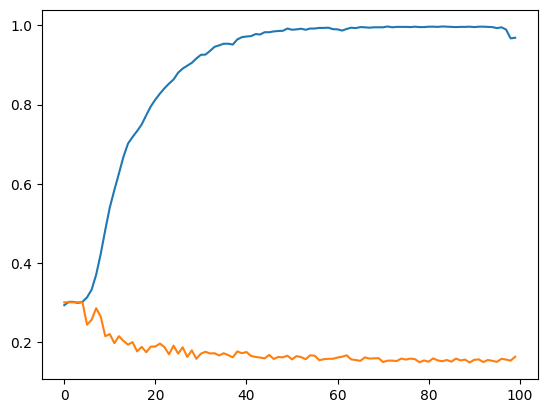

In [86]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.show()

**Test the network with test set of 60 samples (240-299).**

In [87]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder

# Calculate predicted labels
y_pred = model.predict(bag_of_words[3855:])

# Encode true labels using the same LabelEncoder
label_encoder = LabelEncoder()
encoded_true_labels = label_encoder.fit_transform(labels[3855:])

# Calculate confusion matrix
cm = confusion_matrix(encoded_true_labels, y_pred.argmax(axis=1))
print('Confusion Matrix')
print(cm)

# Calculate accuracy
accuracy = accuracy_score(encoded_true_labels, y_pred.argmax(axis=1))
print('Accuracy')
print(accuracy)

# Generate classification report with specified labels
report = classification_report(
    encoded_true_labels,
    y_pred.argmax(axis=1),
    target_names=label_encoder.classes_,
    labels=label_encoder.transform(label_encoder.classes_)
)
print('Classification Report')
print(report)


31/31 [==============================] - 0s 7ms/step
Confusion Matrix
[[100   7   2 ...   2   0   0]
 [ 16   1   1 ...   0   0   2]
 [  1   0   0 ...   0   0   0]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]
Accuracy
0.12461059190031153
Classification Report
              precision    recall  f1-score   support

           E       0.32      0.35      0.34       282
         E,E       0.03      0.02      0.02        53
       E,E,E       0.00      0.00      0.00         4
       E,E,P       0.00      0.00      0.00         4
         E,P       0.00      0.00      0.00        19
       E,P,P       0.00      0.00      0.00         2
       E,P,T       0.00      0.00      0.00         3
         E,T       0.00      0.00      0.00         8
       E,T,P       0.00      0.00      0.00         1
           P       0.50      0.00      0.01       225
         P,E       0.00      0.00      0.00        79
       P,E,E       0.00      0.00     

c:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera